In [1]:
from IPython.display import clear_output

import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures

!pip install catboost
import catboost


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


import matplotlib.pyplot as plt

clear_output()

In [2]:
def feature_importance_with_names(feature_importance, column_names):
    import matplotlib.pyplot as plt

    column_names = np.array(column_names)
    
    sort_order = np.argsort(feature_importance)
    
    feature_importance = feature_importance[sort_order][::-1]
    column_names = column_names[sort_order][::-1]
    
    fig, ax = plt.subplots()
    y_pos = np.arange(len(feature_importance))
    ax.barh(y_pos, feature_importance)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(column_names)
    ax.invert_yaxis() 

    plt.show()   

In [3]:
def show_predictions(title, y_true, y_pred, n = None):
  if n is None:
    show_n_examples = len(y_true)
  else:
    show_n_examples = n
  
  fig, ax = plt.subplots(ncols = 1, figsize = (12, 6))
  ax.plot(range(show_n_examples), y_test[:show_n_examples], label = 'y_test', marker='+')
  ax.plot(range(show_n_examples), y_pred[:show_n_examples], label = 'y_test_predict', marker='o')
  ax.legend()
  fig.suptitle(title)

In [4]:
def plot_regression_model_training_history(model, history, X_test, y_test, title = 'None', metric = 'mean_absolute_error'):
  
  score = model.evaluate(X_test, y_test, verbose = False)

  fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))
  ax[0].plot(history.history['loss'], label = 'loss')
  ax[0].plot(history.history['val_loss'], label = 'val_loss')
  ax[0].set_ylabel('loss')
  ax[0].set_xlabel('epoch')
  ax[0].legend()

  ax[1].plot(history.history[f'{metric}'], label = f'{metric}')
  ax[1].plot(history.history[f'val_{metric}'], label = f'val_{metric}')
  ax[1].set_ylabel(metric)
  ax[1].set_xlabel('epoch')
  ax[1].legend()

  fig.suptitle(title)
  plt.show()
  print('\nmodel training statistics:')
  print(f'loss: {score[0]} |  {metric}: {score[1]}')

In [5]:
def get_results(model_type, y_true, y_pred):
  mae = round(mean_absolute_error(y_true, y_pred), 12)
  print(model_type)
  print(f'mean absolute error: {mae}')

  return mae

In [6]:
data = load_boston()
print(data['DESCR'])
df = pd.DataFrame(data = np.c_[data['data'], data['target']], columns = list(data['feature_names']) + ['target'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [7]:
pf = PolynomialFeatures(interaction_only = True, include_bias = False)

In [8]:
n_features = 5
p_features = pf.fit_transform(df)
p_df = pd.DataFrame(data = p_features[:,14: 14 + n_features], columns = pf.get_feature_names()[14:14 + n_features])

In [9]:
p_df.head()

,x0 x1,x0 x2,x0 x3,x0 x4,x0 x5
0,0.11376,0.014599,0.0,0.003400,0.041554
1,0.00000,0.193082,0.0,0.012808,0.175358
2,0.00000,0.192940,0.0,0.012799,0.196079
3,0.00000,0.070567,0.0,0.014825,0.226525
4,0.00000,0.150529,0.0,0.031625,0.493500


In [10]:
df = df.merge(p_df, left_index=True, right_index=True)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0 x1,x0 x2,x0 x3,x0 x4,x0 x5
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,0.11376,0.014599,0.0,0.003400,0.041554
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,0.00000,0.193082,0.0,0.012808,0.175358
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,0.00000,0.192940,0.0,0.012799,0.196079
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,0.00000,0.070567,0.0,0.014825,0.226525
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,0.00000,0.150529,0.0,0.031625,0.493500


In [11]:
train_df, test_df, _, _ = train_test_split(df, df, test_size=0.2, random_state=42)
train_df = pd.DataFrame(data = train_df, columns = df.columns)
test_df = pd.DataFrame(data = test_df, columns = df.columns)
feature_names = list(train_df.columns)
feature_names.remove('target')

In [12]:
print('df:', df.shape)
print('train_df (90%):', train_df.shape)
print('test_df (10%):', test_df.shape)

df: (506, 19)
train_df (90%): (404, 19)
test_df (10%): (102, 19)


In [13]:
class FeaturePreparator(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      
      return self
    
  def transform(self, X, y=None):
    
    new_X = X.copy()
    del new_X['target']

    return new_X

In [14]:
fe = FeaturePreparator()

In [15]:
X_train = fe.fit_transform(train_df)
X_test = fe.transform(test_df)

y_train = train_df['target']
y_test = test_df['target']

In [16]:
results = []

LinearRegression
mean absolute error: 2.843144670262


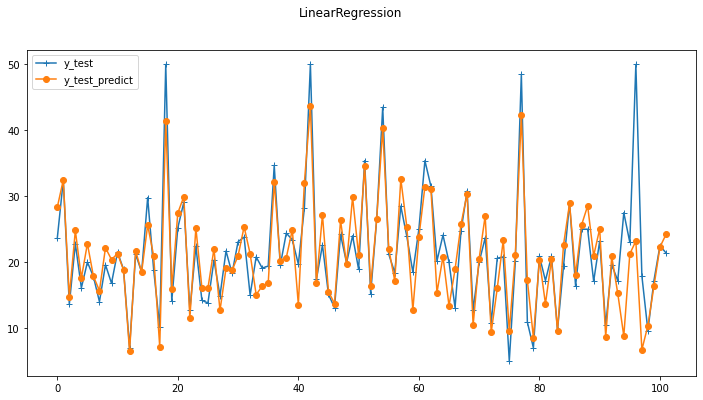

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_model_type = 'LinearRegression'
lr_predictions = lr.predict(X_test)

lr_mae = get_results(lr_model_type, y_test, lr_predictions)
show_predictions(lr_model_type, y_test, lr_predictions)

results.append(dict(model_type = lr_model_type, mae = lr_mae))

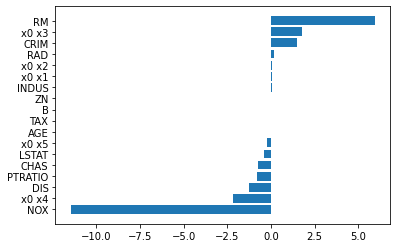

In [18]:
feature_importance_with_names(lr.coef_, feature_names)

RandomForestRegressor
mean absolute error: 2.129960784314


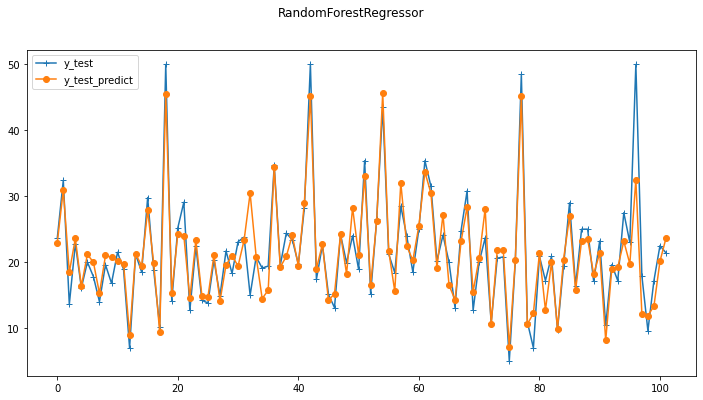

In [19]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

rfr_model_type = 'RandomForestRegressor'
rfr_predictions = rfr.predict(X_test)

rfr_mae = get_results(rfr_model_type, y_test, rfr_predictions)
show_predictions(rfr_model_type, y_test, rfr_predictions)

results.append(dict(model_type = rfr_model_type, mae = rfr_mae))

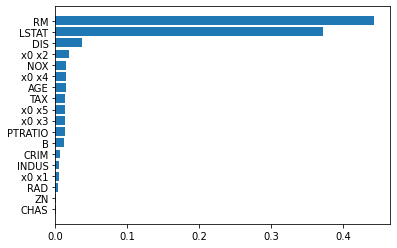

In [20]:
feature_importance_with_names(rfr.feature_importances_, feature_names)

CatBoostRegressor
mean absolute error: 1.822905613085


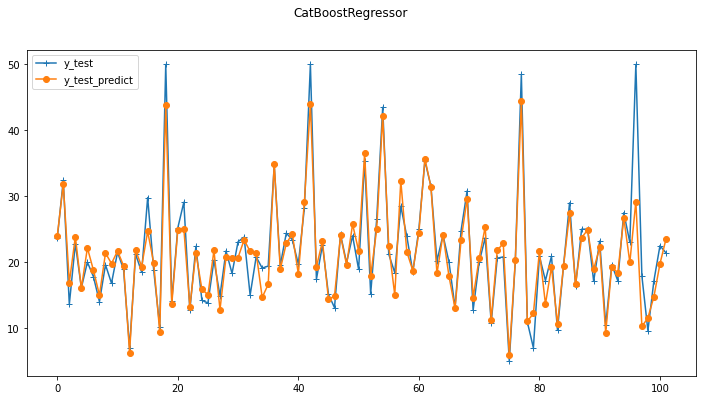

In [21]:
cbr = catboost.CatBoostRegressor()
cbr.fit(X_train, y_train, verbose=False)

cbr_model_type = 'CatBoostRegressor'
cbr_predictions = cbr.predict(X_test)

cbr_mae = get_results(cbr_model_type, y_test, cbr_predictions)
show_predictions(cbr_model_type, y_test, cbr_predictions)


results.append(dict(model_type = cbr_model_type, mae = cbr_mae))

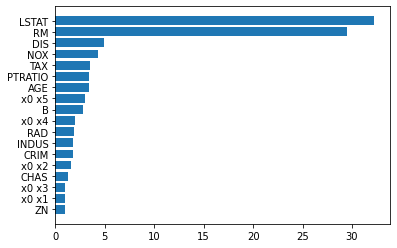

In [22]:
feature_importance_with_names(cbr.feature_importances_, cbr.feature_names_)

In [23]:
n_dimensions = X_train.shape[1]

mean absolute error: 3.299732066895


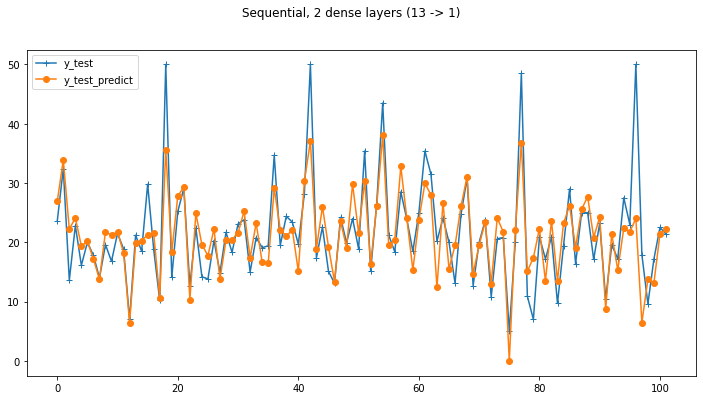

In [44]:
nn = Sequential(
    [
     Dense(13, activation='relu', input_shape = (n_dimensions,)),
     Dense(1, activation='linear')
    ]
)

nn.compile(loss='mean_absolute_error', optimizer = "adam", metrics = ['mean_absolute_error'])
nn_history = nn.fit(X_train, y_train, batch_size = 2, epochs = 100, verbose = 0, validation_split=0.1)

nn_model_type = 'Sequential, 2 dense layers (13 -> 1)'
nn_predictions = nn.predict(X_test)

nn_mae = get_results(nn, y_test, nn.predict(X_test))
show_predictions(nn_model_type, y_test, nn_predictions)

results.append(dict(model_type = nn_model_type, mae = nn_mae))

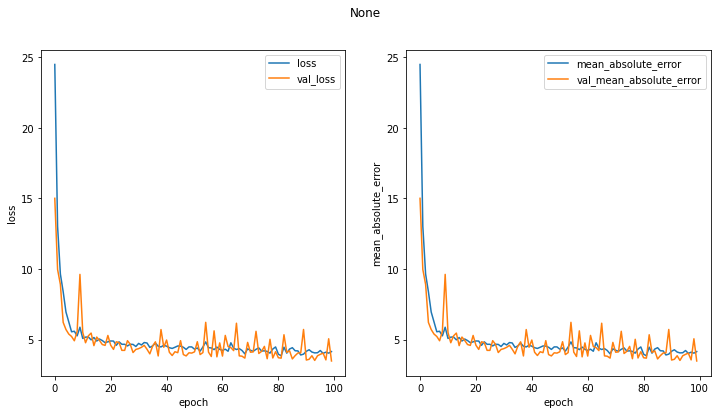


model training statistics:
loss: 3.299731731414795 |  mean_absolute_error: 3.299731731414795


In [45]:
plot_regression_model_training_history(nn, nn_history, X_test, y_test)